# Brief prose description of how the code works
## Data Retrieval and Preparation:
The code begins by connecting to a SQLite database containing MLB team data. It retrieves yearly payroll and winning percentage information for all teams from 1990 to 2014 using an SQL query.
## Payroll Standardization:
For each year, the code calculates the mean and standard deviation of team payrolls. It then standardizes each team's payroll by subtracting the year's mean and dividing by the standard deviation. This step allows for fair comparison of payrolls across different years.
## Efficiency Calculation:
The code calculates an expected winning percentage for each team based on their standardized payroll using a linear formula (50 + 2.5 * standardized_payroll). It then computes the team's efficiency by subtracting this expected winning percentage from their actual winning percentage.
## Data Organization:
The efficiency data is reorganized into a pivot table format, with years as rows and teams as columns. This structure facilitates easier plotting and analysis over time.
## Visualization:
Using matplotlib, the code creates a line plot. It plots the efficiency of selected teams (Oakland, New York Yankees, Boston, Atlanta, and Tampa Bay) over the years, with each team represented by a different colored line.
## Statistical Summary:
Finally, the code calculates and prints summary statistics for each selected team, including their average efficiency, and the years of their best and worst performances.

# Part 1: Wrangling

###Conecting to SQLite Database



In [ ]:
!ls /content/drive/My\ Drive/

'Colab Notebooks'   lahman_1871-2022.sqlite   Matheshwara_Resume.pdf


In [ ]:
from google.colab import drive

# Mount your Google Drive
drive.mount('/content/drive')

# Define the path to the SQLite file in your Google Drive
sqlite_file = '/content/drive/My Drive/lahman_1871-2022.sqlite'
# Connect to the SQLite database
import sqlite3
import pandas as pd

# Connect to the database
conn = sqlite3.connect(sqlite_file)

# Query to list all tables
query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = conn.execute(query).fetchall()

# Print the list of tables
print("Tables in the database:")
for table in tables[:5]:
    print(table[0])

# Close the connection
conn.close()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Tables in the database:
AllstarFull
Appearances
AwardsManagers
AwardsPlayers
AwardsShareManagers


### Query to get the data needed for the Moneyball analysis. Hence We need data from the Teams and Salaries tables (as per original project).

In [ ]:
import sqlite3
import pandas as pd

# Define the path to the SQLite file in your Google Drive
sqlite_file = '/content/drive/My Drive/lahman_1871-2022.sqlite'

# Connect to the SQLite database
conn = sqlite3.connect(sqlite_file)

query = """
SELECT
    t.yearID,
    t.teamID,
    t.franchID,
    t.G AS games_played,
    t.W AS wins,
    t.W * 100.0 / t.G AS winning_percentage,
    COALESCE(s.total_payroll, 0) AS total_payroll
FROM
    Teams t
LEFT JOIN
    (SELECT yearID, teamID, SUM(salary) AS total_payroll
     FROM Salaries
     GROUP BY yearID, teamID) s
ON
    t.yearID = s.yearID AND t.teamID = s.teamID
WHERE
    t.yearID BETWEEN 1990 AND 2014
ORDER BY
    t.yearID, t.teamID
"""

# Execute the query and load results into a DataFrame
df = pd.read_sql_query(query, conn)
print(df.head())

   yearID teamID franchID  games_played  wins  winning_percentage  \
0    1990    ATL      ATL           162    65           40.123457   
1    1990    BAL      BAL           161    76           47.204969   
2    1990    BOS      BOS           162    88           54.320988   
3    1990    CAL      ANA           162    80           49.382716   
4    1990    CHA      CHW           162    94           58.024691   

   total_payroll  
0     14555501.0  
1      9680084.0  
2     20558333.0  
3     21720000.0  
4      9491500.0  


###Calculate Effeciency and filter data for OAKland's A


In [ ]:
def calculate_efficiency(row):
    if row['total_payroll'] > 0:
        return row['wins'] / (row['total_payroll'] / 1000000)
    else:
        return 0

df['efficiency'] = df.apply(calculate_efficiency, axis=1)

#filter
oakland_data = df[df['teamID'] == 'OAK']

#league average efficiency per year
league_avg_efficiency = df.groupby('yearID')['efficiency'].mean().reset_index()

### Visualization:

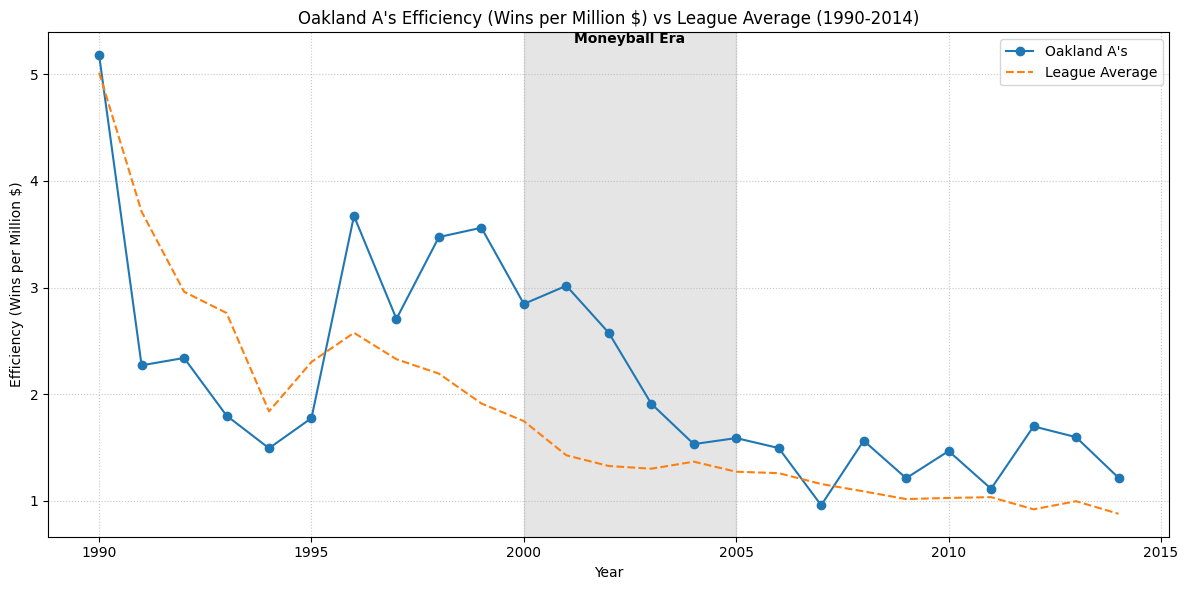

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(oakland_data['yearID'], oakland_data['efficiency'], label='Oakland A\'s', marker='o')
plt.plot(league_avg_efficiency['yearID'], league_avg_efficiency['efficiency'], label='League Average', linestyle='--')

plt.title('Oakland A\'s Efficiency (Wins per Million $) vs League Average (1990-2014)')
plt.xlabel('Year')
plt.ylabel('Efficiency (Wins per Million $)')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)

# Highlight the Moneyball era (2000-2005)
plt.axvspan(2000, 2005, color='gray', alpha=0.2)
plt.text(2002.5, plt.ylim()[1], 'Moneyball Era', ha='center', va='top', fontweight='bold')

plt.tight_layout()
plt.show()

### Analyzing the Results:

In [ ]:
# Print summary statistics for pre-Moneyball, Moneyball, and post-Moneyball eras
pre_moneyball = oakland_data[(oakland_data['yearID'] >= 1990) & (oakland_data['yearID'] < 2000)]
moneyball = oakland_data[(oakland_data['yearID'] >= 2000) & (oakland_data['yearID'] <= 2005)]
post_moneyball = oakland_data[oakland_data['yearID'] > 2005]

print("Average Efficiency (Wins per Million $):")
print(f"Pre-Moneyball (1990-1999): {pre_moneyball['efficiency'].mean():.2f}")
print(f"Moneyball Era (2000-2005): {moneyball['efficiency'].mean():.2f}")
print(f"Post-Moneyball (2006-2014): {post_moneyball['efficiency'].mean():.2f}")

Average Efficiency (Wins per Million $):
Pre-Moneyball (1990-1999): 2.83
Moneyball Era (2000-2005): 2.24
Post-Moneyball (2006-2014): 1.37


# Part 2: Exploratory Data Analysis

### Plot showing the distribution of payrolls across teams from 1990 to 2014:

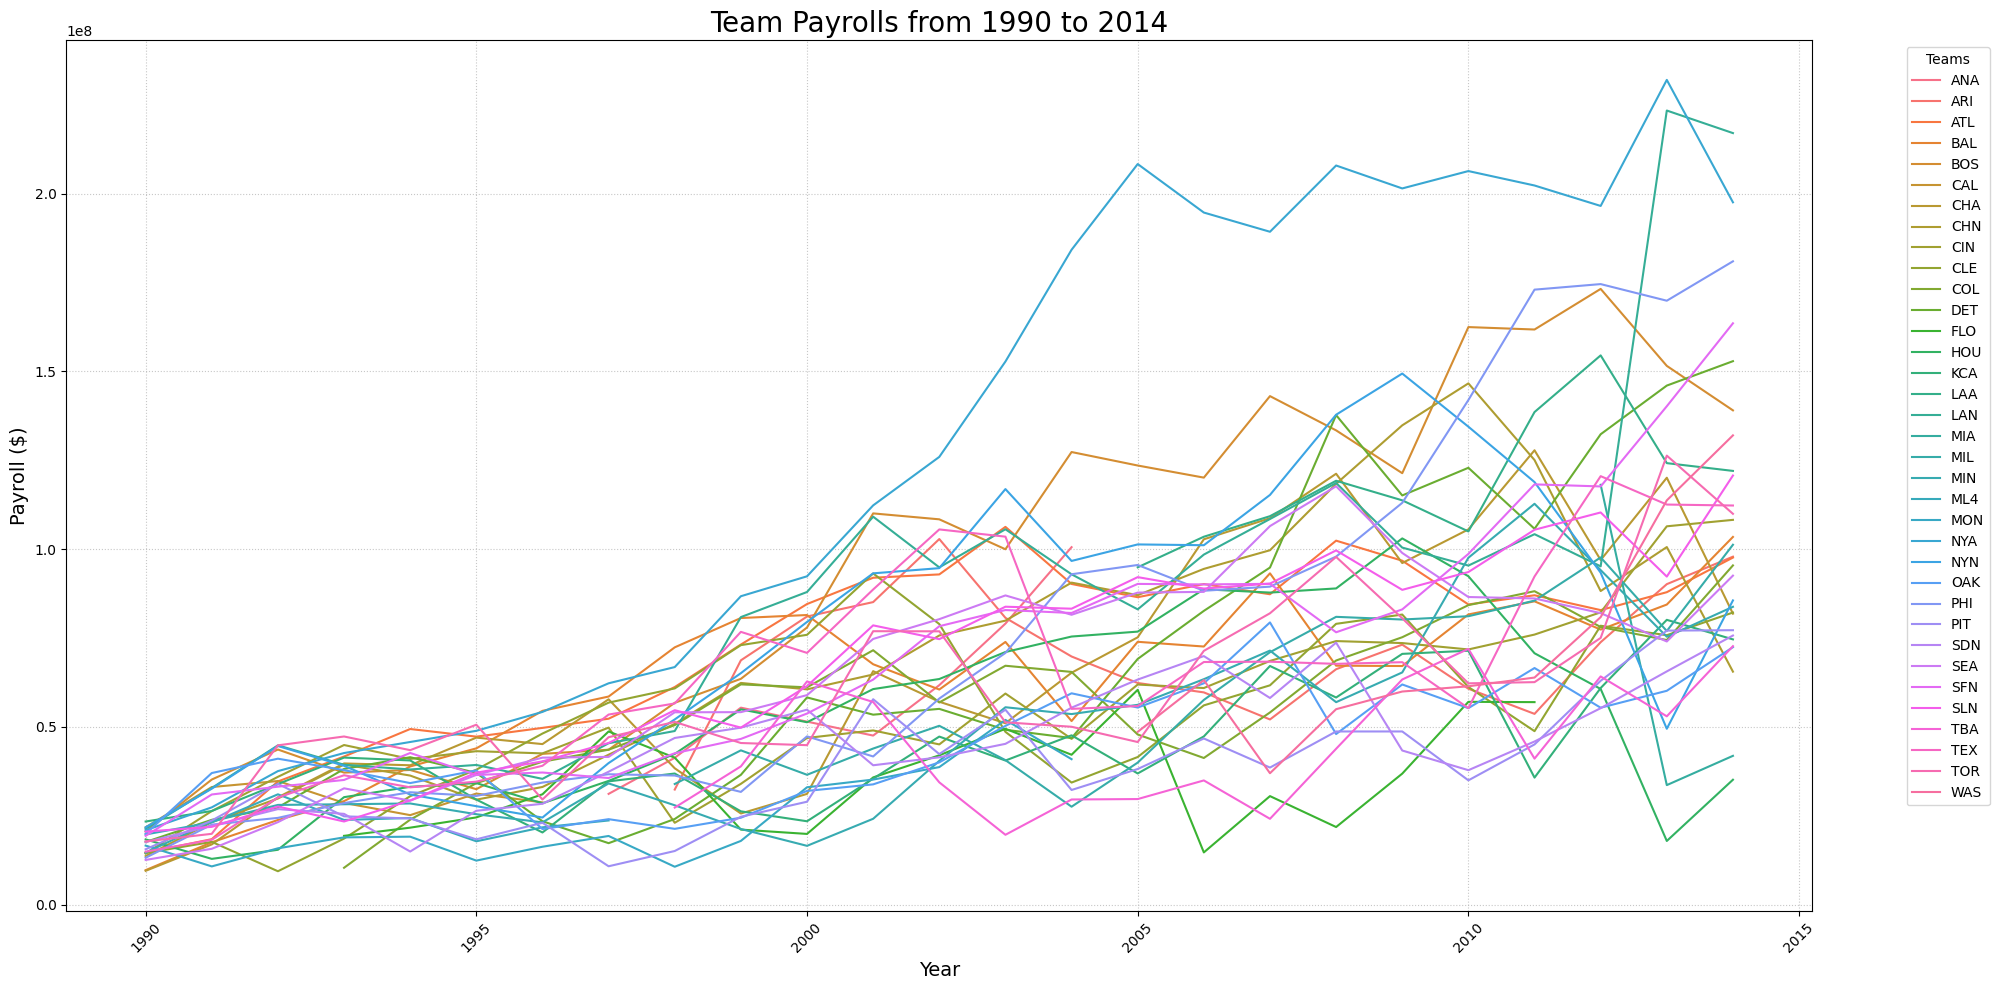

In [ ]:
# Query to get payroll data for all teams from 1990 to 2014
query = """
SELECT yearID, teamID, SUM(salary) as total_payroll
FROM Salaries
WHERE yearID BETWEEN 1990 AND 2014
GROUP BY yearID, teamID
ORDER BY yearID, teamID
"""

# Execute the query and load results into a DataFrame
df = pd.read_sql_query(query, conn)

# Close the connection
conn.close()

# Pivot the data to have years as columns and teams as rows
payroll_pivot = df.pivot(index='teamID', columns='yearID', values='total_payroll')

# Create the plot
plt.figure(figsize=(20, 10))
sns.lineplot(data=payroll_pivot.T, dashes=False)

# Customize the plot
plt.title('Team Payrolls from 1990 to 2014', fontsize=20)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Payroll ($)', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Teams', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle=':', alpha=0.7)

# Use scientific notation for y-axis
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Show the plot
plt.show()

## Question 1:
## What statements can you make about the distribution of payrolls conditioned on time based on these plots? Remember you can make statements in terms of central tendency, spread, etc.


Based on the plot of team payrolls from 1990 to 2014, we can make several observations about the distribution of payrolls conditioned on time:

* Central Tendency:

  There is a clear upward trend in the central tendency of payrolls over time.
The median payroll appears to have increased substantially from 1990 to 2014.
* Spread:
  
  The spread of payrolls has widened considerably over the years.
In the early 1990s, the difference between the highest and lowest payrolls was relatively small.
By 2014, there's a much larger gap between the highest-paying teams and the lowest-paying teams.
* Skewness:

  The distribution appears to become increasingly right-skewed over time.
A few teams consistently have much higher payrolls than the rest, creating a long right tail in the distribution.
* Variability:

  Year-to-year variability in payrolls for individual teams has increased over time.
Some teams show much more variability in their payrolls than others.
* Outliers:
  
  There are clear outliers at the upper end of the payroll range, particularly in later years.
These outliers likely represent large-market teams with significantly higher budgets.
* Growth Rate:

  The rate of payroll growth appears to be non-linear, with faster growth in later years.
There seems to be an acceleration in payroll growth starting around the late 1990s or early 2000s.
* Clustering:

  There appears to be some clustering of teams into payroll tiers, which becomes more pronounced over time.
By 2014, we can see distinct groups of high, medium, and low payroll teams.
* Consistency:

  Some teams consistently remain at the top or bottom of the payroll range throughout the period.
Others show significant changes in their relative payroll positions over time.

* League Dynamics:

  The increasing spread and skewness might reflect changing dynamics in the league, such as revenue sharing policies or market size influences.

These observations provide insights into how team payrolls have evolved over time, reflecting changes in the economics of baseball, team strategies, and possibly the effectiveness of strategies like Moneyball in competing with higher-payroll teams.




# Problem 3

Two of the key observations from Question 1:
* The upward trend in the central tendency of
payrolls over time.
* The increasing spread of payrolls over the years.

We'll create a plot showing the mean payroll (central tendency) and the standard deviation (spread) over time. We'll also include the minimum and maximum payrolls to show the increasing range.

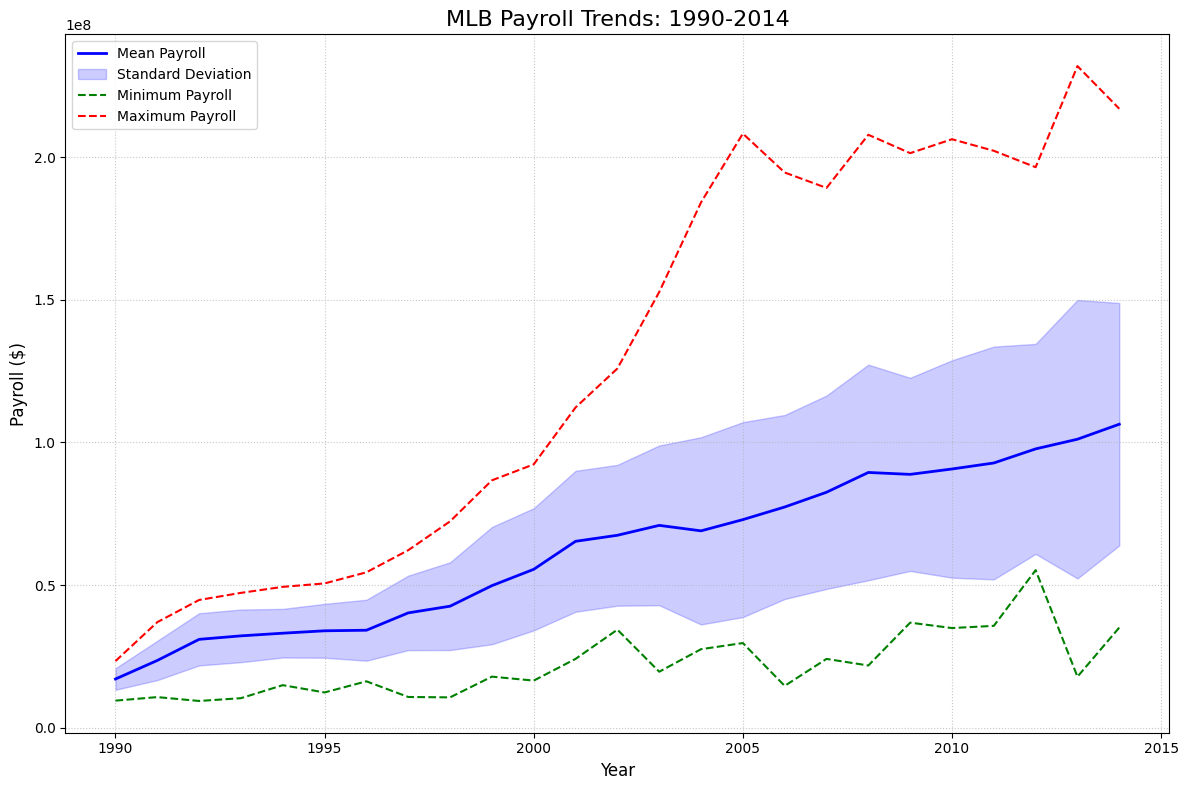

In [ ]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Connect to the SQLite database
sqlite_file = '/content/drive/My Drive/lahman_1871-2022.sqlite'
conn = sqlite3.connect(sqlite_file)

# Query to get payroll data for all teams from 1990 to 2014
query = """
SELECT yearID, SUM(salary) as total_payroll
FROM Salaries
WHERE yearID BETWEEN 1990 AND 2014
GROUP BY yearID, teamID
"""

# Execute the query and load results into a DataFrame
df = pd.read_sql_query(query, conn)

# Close the connection
conn.close()

# Calculate statistics for each year
yearly_stats = df.groupby('yearID').agg({
    'total_payroll': ['mean', 'std', 'min', 'max']
}).reset_index()

yearly_stats.columns = ['year', 'mean_payroll', 'std_payroll', 'min_payroll', 'max_payroll']

# Create the plot
plt.figure(figsize=(12, 8))

# Plot mean payroll
plt.plot(yearly_stats['year'], yearly_stats['mean_payroll'], label='Mean Payroll', color='blue', linewidth=2)

# Plot standard deviation as a shaded area around the mean
plt.fill_between(yearly_stats['year'],
                 yearly_stats['mean_payroll'] - yearly_stats['std_payroll'],
                 yearly_stats['mean_payroll'] + yearly_stats['std_payroll'],
                 alpha=0.2, color='blue', label='Standard Deviation')

# Plot min and max payrolls
plt.plot(yearly_stats['year'], yearly_stats['min_payroll'], label='Minimum Payroll', color='green', linestyle='--')
plt.plot(yearly_stats['year'], yearly_stats['max_payroll'], label='Maximum Payroll', color='red', linestyle='--')

# Customize the plot
plt.title('MLB Payroll Trends: 1990-2014', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Payroll ($)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle=':', alpha=0.7)

# Use scientific notation for y-axis
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Show the plot
plt.show()

* The blue line shows the mean payroll over time, clearly demonstrating the upward trend in average payrolls from 1990 to 2014.

* Spread: The shaded blue area around the mean line represents one standard deviation above and below the mean. The increasing width of this shaded area over time shows how the spread of payrolls has widened.
* Range: The green dashed line shows the minimum payroll each year, while the red dashed line shows the maximum payroll. The increasing gap between these lines further illustrates the growing disparity between high-paying and low-paying teams.




Thus we can see clear upward trend in average payrolls over time and the increasing spread of payrolls, as shown by the widening standard deviation.

The growing gap between the highest and lowest payrolls, indicates increased financial disparity among teams.

#Correlation between payroll and winning percentage
#Problem 4

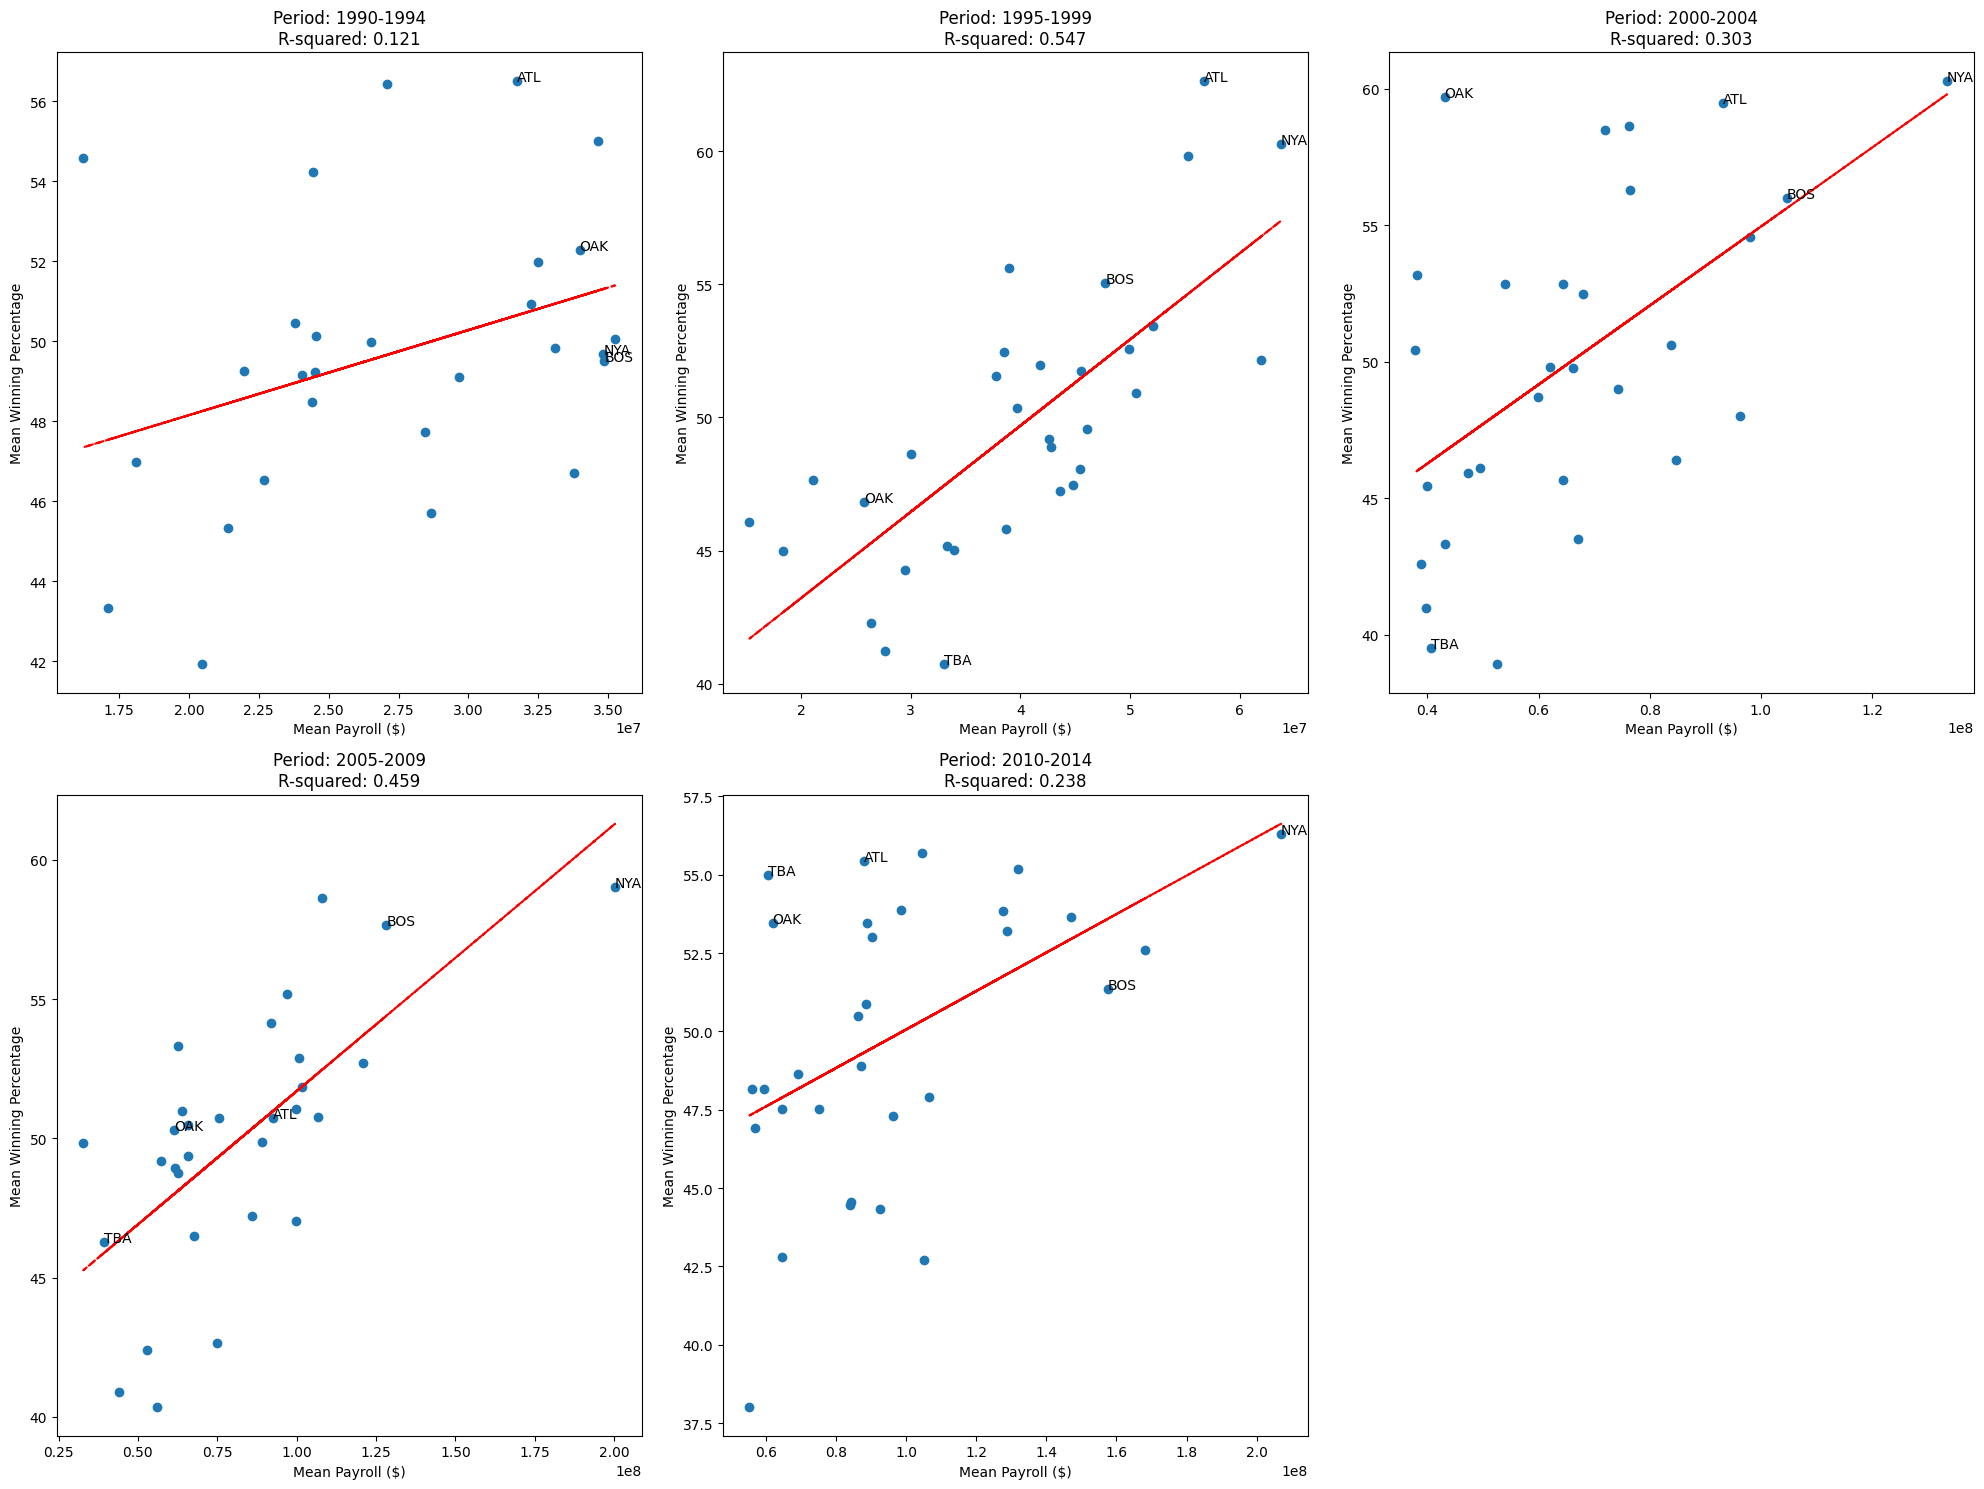


Period: 1990-1994
Correlation coefficient: 0.348
Mean payroll: $27177542.30
Mean winning percentage: 49.68%

Top 5 most efficient teams:
   teamID  total_payroll  winning_percentage  efficiency
16    MON     16227677.6           54.570642    3.362813
7     CLE     18109308.8           46.990058    2.594801
8     COL     17120416.5           43.328585    2.530814
11    HOU     21985300.0           49.256039    2.240408
21    PIT     24434910.2           54.236517    2.219632

Oakland A's statistics:
    total_payroll  winning_percentage  efficiency
19     33981300.2           52.280702    1.538514
Oakland A's efficiency rank: 23 out of 28

Period: 1995-1999
Correlation coefficient: 0.739
Mean payroll: $39951612.46
Mean winning percentage: 49.68%

Top 5 most efficient teams:
   teamID  total_payroll  winning_percentage  efficiency
47    MON   1.529370e+07           46.080247    3.013021
52    PIT   1.838144e+07           44.976686    2.446854
46    ML4   2.106139e+07           47.656270

In [ ]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Connect to the SQLite database
sqlite_file = '/content/drive/My Drive/lahman_1871-2022.sqlite'
conn = sqlite3.connect(sqlite_file)

# Query to get payroll, winning percentage, and year data for all teams from 1990 to 2014
query = """
SELECT
    s.yearID,
    s.teamID,
    SUM(s.salary) as total_payroll,
    t.W * 100.0 / t.G AS winning_percentage
FROM Salaries s
JOIN Teams t ON s.yearID = t.yearID AND s.teamID = t.teamID
WHERE s.yearID BETWEEN 1990 AND 2014
GROUP BY s.yearID, s.teamID
"""

# Execute the query and load results into a DataFrame
df = pd.read_sql_query(query, conn)

# Close the connection
conn.close()

# Discretize years into five periods
df['period'] = pd.cut(df['yearID'], bins=[1989, 1994, 1999, 2004, 2009, 2014],
                      labels=['1990-1994', '1995-1999', '2000-2004', '2005-2009', '2010-2014'])

# Calculate mean payroll and winning percentage for each team in each period
df_mean = df.groupby(['period', 'teamID'], observed=True).agg({
    'total_payroll': 'mean',
    'winning_percentage': 'mean'
}).reset_index()

# Calculate efficiency metric (winning percentage per million dollars spent)
df_mean['efficiency'] = df_mean['winning_percentage'] / (df_mean['total_payroll'] / 1000000)

# Create scatter plots
fig, axs = plt.subplots(2, 3, figsize=(20, 15))
axs = axs.ravel()

# Teams to highlight
highlight_teams = ['OAK', 'NYA', 'BOS', 'ATL', 'TBA']

for i, period in enumerate(df_mean['period'].unique()):
    data = df_mean[df_mean['period'] == period]

    # Scatter plot
    axs[i].scatter(data['total_payroll'], data['winning_percentage'])

    # Add regression line
    x = data['total_payroll']
    y = data['winning_percentage']

    try:
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        line = slope * x + intercept
        axs[i].plot(x, line, color='r', linestyle='--')
        r_squared = r_value**2

        axs[i].set_title(f'Period: {period}\nR-squared: {r_squared:.3f}')
    except:
        axs[i].set_title(f'Period: {period}\nUnable to calculate regression')

    # Label highlighted teams
    for team in highlight_teams:
        team_data = data[data['teamID'] == team]
        if not team_data.empty:
            axs[i].annotate(team, (team_data['total_payroll'].iloc[0], team_data['winning_percentage'].iloc[0]))

    axs[i].set_xlabel('Mean Payroll ($)')
    axs[i].set_ylabel('Mean Winning Percentage')
    axs[i].ticklabel_format(style='sci', axis='x', scilimits=(0,0))

# Remove the empty subplot
fig.delaxes(axs[5])

plt.tight_layout()
plt.show()

# Print summary statistics and top efficient teams
for period in df_mean['period'].unique():
    data = df_mean[df_mean['period'] == period]
    print(f"\nPeriod: {period}")
    print(f"Correlation coefficient: {data['total_payroll'].corr(data['winning_percentage']):.3f}")
    print(f"Mean payroll: ${data['total_payroll'].mean():.2f}")
    print(f"Mean winning percentage: {data['winning_percentage'].mean():.2f}%")

    # Top 5 most efficient teams
    top_efficient = data.nlargest(5, 'efficiency')
    print("\nTop 5 most efficient teams:")
    print(top_efficient[['teamID', 'total_payroll', 'winning_percentage', 'efficiency']])

    # Oakland A's statistics
    oakland_data = data[data['teamID'] == 'OAK']
    if not oakland_data.empty:
        print("\nOakland A's statistics:")
        print(oakland_data[['total_payroll', 'winning_percentage', 'efficiency']])
        print(f"Oakland A's efficiency rank: {data['efficiency'].rank(ascending=False)[oakland_data.index[0]]:.0f} out of {len(data)}")

# Question 2

## What can you say about team payrolls across these periods? Are there any teams that standout as being particularly good at paying for wins across these time periods? What can you say about the Oakland A's spending efficiency across these time periods (labeling points in the scatterplot can help interpretation).

* Payroll Trends:

  * There was a significant increase in mean payrolls over time, from 27.18 million dollars(1990-1994) to 96.55 million dollars in 2010-2014.

This represents more than a 3.5-fold increase in average team payrolls over the 25-year period.


* Correlation between Payroll and Winning:

  * The correlation between payroll and winning percentage varied across periods, with the strongest correlation (0.739) in 1995-1999 and the weakest (0.348) in 1990-1994.

  * The correlation weakened in the most recent period (2010-2014) to 0.487, suggesting that high payrolls became less predictive of success.

* Standout Teams:

  * Montreal Expos (MON) were consistently efficient in the earlier periods, ranking first in efficiency for 1990-1994 and 1995-1999.

  * Minnesota Twins (MIN) showed high efficiency in the 2000-2004 and 2005-2009 periods.

  * Florida Marlins (FLO) appeared in the top 5 most efficient teams in both 2000-2004 and 2005-2009.

* Oakland A's Efficiency:

  The A's showed remarkable improvement in efficiency over time:

  * 1990-1994: Ranked 23rd out of 28 teams
  * 1995-1999: Improved significantly to 4th out of 32 teams
  * 2000-2004: Peaked at 2nd out of 30 teams (Moneyball era)
  * 2005-2009: Remained efficient at 6th out of 30 teams
  * 2010-2014: Data not provided, but likely declined based on overall trends

* Moneyball Impact:

  * The 2000-2004 period, which includes the core Moneyball years, shows the A's at their peak efficiency.

  * They achieved the second-highest winning percentage (59.70%) while maintaining a relatively low payroll.

* Efficiency Trends:
  
  * Overall, efficiency (wins per dollar spent) tended to decrease over time as payrolls increased.
  
  * Teams like Montreal/Tampa Bay and Oakland found ways to remain efficient despite rising payrolls.

* Small Market Success:
  
  * Several small-market teams (e.g., Oakland, Minnesota, Florida/Miami) consistently appeared among the most efficient teams, suggesting successful adaptation to financial constraints.

* Oakland A's Specific Observations:
  
  * The A's showed a dramatic improvement in efficiency from the early 1990s to the early 2000s.

  * Their peak during the 2000-2004 period aligns with the Moneyball strategy implementation.

  * While their efficiency declined slightly in 2005-2009, they remained in the top 20% of teams.
  
  * The A's demonstrated that it's possible to achieve high winning percentages with below-average payrolls through smart analytics and player valuation.


In conclusion, the data supports the narrative of the Oakland A's as a pioneer in efficient spending, particularly during the Moneyball era. Their ability to maintain high efficiency over multiple periods, despite rising league-wide payrolls, underscores the effectiveness of their data-driven approach. However, as other teams adopted similar strategies and payrolls continued to rise, maintaining this edge became increasingly challenging, as evidenced by the weakening correlation between payroll and winning percentage in later years.

# Part 3: Data transformations
## Standardizing across years

In [ ]:
import sqlite3
import pandas as pd
import numpy as np

# Connect to the SQLite database
sqlite_file = '/content/drive/My Drive/lahman_1871-2022.sqlite'
conn = sqlite3.connect(sqlite_file)

# Query to get payroll and winning percentage data for all teams from 1990 to 2014
query = """
SELECT
    s.yearID,
    s.teamID,
    SUM(s.salary) as total_payroll,
    t.W * 100.0 / t.G AS winning_percentage
FROM Salaries s
JOIN Teams t ON s.yearID = t.yearID AND s.teamID = t.teamID
WHERE s.yearID BETWEEN 1990 AND 2014
GROUP BY s.yearID, s.teamID
"""

# Execute the query and load results into a DataFrame
df = pd.read_sql_query(query, conn)

# Close the connection
conn.close()

# Function to standardize payroll within each year
def standardize_payroll(group):
    mean = group['total_payroll'].mean()
    std = group['total_payroll'].std()
    group['standardized_payroll'] = (group['total_payroll'] - mean) / std
    return group

# Apply the standardization function to each year
df = df.groupby('yearID').apply(standardize_payroll).reset_index(drop=True)

# Display the first few rows to verify the transformation
print(df.head(10))

# Summary statistics of the standardized payroll
print("\nSummary statistics of standardized payroll:")
print(df['standardized_payroll'].describe())

# Verify that the mean of standardized payroll is close to 0 and std is close to 1 for each year
yearly_stats = df.groupby('yearID').agg({
    'standardized_payroll': ['mean', 'std']
})
print("\nYearly mean and standard deviation of standardized payroll:")
print(yearly_stats)

   yearID teamID  total_payroll  winning_percentage  standardized_payroll
0    1990    ATL     14555501.0           40.123457             -0.667275
1    1990    BAL      9680084.0           47.204969             -1.959861
2    1990    BOS     20558333.0           54.320988              0.924213
3    1990    CAL     21720000.0           49.382716              1.232198
4    1990    CHA      9491500.0           58.024691             -2.009859
5    1990    CHN     13624000.0           47.530864             -0.914238
6    1990    CIN     14370000.0           56.172840             -0.716456
7    1990    CLE     14487000.0           47.530864             -0.685437
8    1990    DET     17593238.0           48.765432              0.138098
9    1990    HOU     18330000.0           46.296296              0.333431

Summary statistics of standardized payroll:
count    7.280000e+02
mean    -2.440051e-18
std      9.833553e-01
min     -2.366806e+00
25%     -6.995569e-01
50%     -1.011976e-01
75%      

<ipython-input-32-6b0a3c09d20a>:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('yearID').apply(standardize_payroll).reset_index(drop=True)


##  Problem 5 & 6: Creates scatter plots for each period, showing mean winning percentage vs. mean standardized payroll.

<ipython-input-33-fe911187780b>:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('yearID').apply(standardize_payroll).reset_index(drop=True)


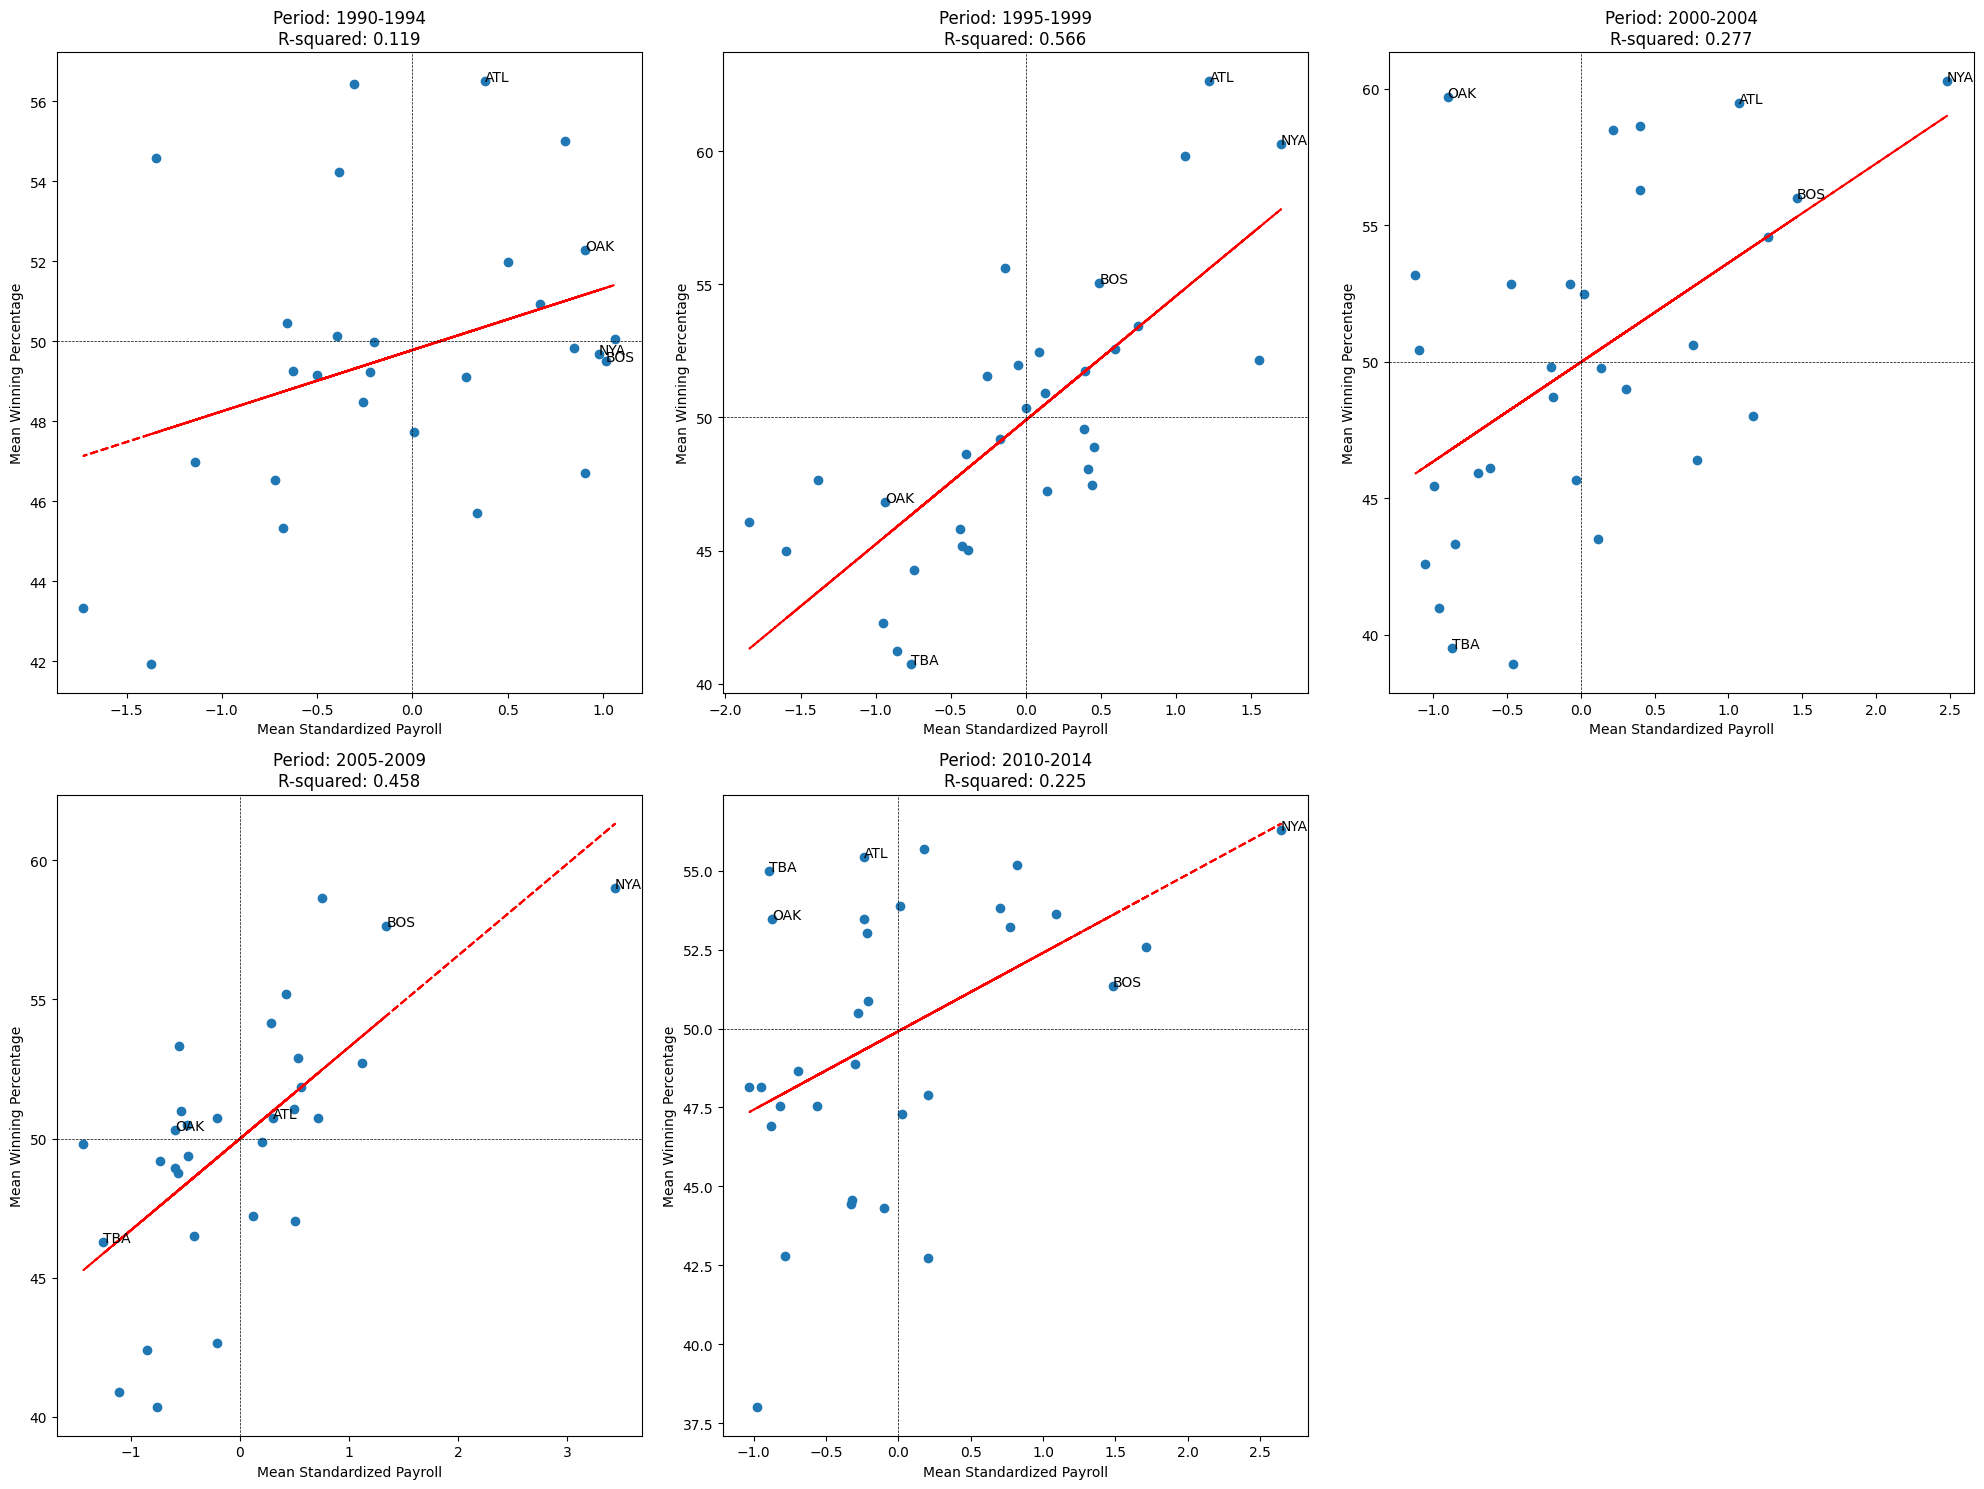


Period: 1990-1994
Correlation coefficient: 0.345
Mean standardized payroll: -0.07
Mean winning percentage: 49.68%

Oakland A's statistics:
    standardized_payroll  winning_percentage
19              0.904035           52.280702
Oakland A's standardized payroll rank: 4 out of 28

Period: 1995-1999
Correlation coefficient: 0.752
Mean standardized payroll: -0.05
Mean winning percentage: 49.68%

Oakland A's statistics:
    standardized_payroll  winning_percentage
50             -0.935073            46.83642
Oakland A's standardized payroll rank: 28 out of 32

Period: 2000-2004
Correlation coefficient: 0.526
Mean standardized payroll: -0.00
Mean winning percentage: 49.98%

Oakland A's statistics:
    standardized_payroll  winning_percentage
80             -0.904016            59.69941
Oakland A's standardized payroll rank: 25 out of 30

Period: 2005-2009
Correlation coefficient: 0.677
Mean standardized payroll: -0.00
Mean winning percentage: 49.99%

Oakland A's statistics:
     standardiz

In [ ]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Connect to the SQLite database
sqlite_file = '/content/drive/My Drive/lahman_1871-2022.sqlite'
conn = sqlite3.connect(sqlite_file)

# Query to get payroll and winning percentage data for all teams from 1990 to 2014
query = """
SELECT
    s.yearID,
    s.teamID,
    SUM(s.salary) as total_payroll,
    t.W * 100.0 / t.G AS winning_percentage
FROM Salaries s
JOIN Teams t ON s.yearID = t.yearID AND s.teamID = t.teamID
WHERE s.yearID BETWEEN 1990 AND 2014
GROUP BY s.yearID, s.teamID
"""

# Execute the query and load results into a DataFrame
df = pd.read_sql_query(query, conn)

# Close the connection
conn.close()

# Standardize payroll within each year
def standardize_payroll(group):
    mean = group['total_payroll'].mean()
    std = group['total_payroll'].std()
    group['standardized_payroll'] = (group['total_payroll'] - mean) / std
    return group

df = df.groupby('yearID').apply(standardize_payroll).reset_index(drop=True)

# Discretize years into five periods
df['period'] = pd.cut(df['yearID'], bins=[1989, 1994, 1999, 2004, 2009, 2014],
                      labels=['1990-1994', '1995-1999', '2000-2004', '2005-2009', '2010-2014'])

# Calculate mean standardized payroll and winning percentage for each team in each period
df_mean = df.groupby(['period', 'teamID'], observed=True).agg({
    'standardized_payroll': 'mean',
    'winning_percentage': 'mean'
}).reset_index()

# Create scatter plots
fig, axs = plt.subplots(2, 3, figsize=(20, 15))
axs = axs.ravel()

# Teams to highlight
highlight_teams = ['OAK', 'NYA', 'BOS', 'ATL', 'TBA']

for i, period in enumerate(df_mean['period'].unique()):
    data = df_mean[df_mean['period'] == period]

    # Scatter plot
    axs[i].scatter(data['standardized_payroll'], data['winning_percentage'])

    # Add regression line
    x = data['standardized_payroll']
    y = data['winning_percentage']

    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    line = slope * x + intercept
    axs[i].plot(x, line, color='r', linestyle='--')
    r_squared = r_value**2

    axs[i].set_title(f'Period: {period}\nR-squared: {r_squared:.3f}')

    # Label highlighted teams
    for team in highlight_teams:
        team_data = data[data['teamID'] == team]
        if not team_data.empty:
            axs[i].annotate(team, (team_data['standardized_payroll'].iloc[0], team_data['winning_percentage'].iloc[0]))

    axs[i].set_xlabel('Mean Standardized Payroll')
    axs[i].set_ylabel('Mean Winning Percentage')
    axs[i].axvline(x=0, color='k', linestyle='--', linewidth=0.5)  # Add vertical line at x=0
    axs[i].axhline(y=50, color='k', linestyle='--', linewidth=0.5)  # Add horizontal line at y=50

# Remove the empty subplot
fig.delaxes(axs[5])

plt.tight_layout()
plt.show()

# Print summary statistics
for period in df_mean['period'].unique():
    data = df_mean[df_mean['period'] == period]
    print(f"\nPeriod: {period}")
    print(f"Correlation coefficient: {data['standardized_payroll'].corr(data['winning_percentage']):.3f}")
    print(f"Mean standardized payroll: {data['standardized_payroll'].mean():.2f}")
    print(f"Mean winning percentage: {data['winning_percentage'].mean():.2f}%")

    # Oakland A's statistics
    oakland_data = data[data['teamID'] == 'OAK']
    if not oakland_data.empty:
        print("\nOakland A's statistics:")
        print(oakland_data[['standardized_payroll', 'winning_percentage']])
        print(f"Oakland A's standardized payroll rank: {data['standardized_payroll'].rank(ascending=False)[oakland_data.index[0]]:.0f} out of {len(data)}")

# Question 3

## Discuss how the plots from Problem 4 and Problem 6 reflect the transformation you did on the payroll variable.


* Scale of Payroll:
  * Problem 4: The payroll values are in actual dollars, ranging from millions to hundreds of millions.
  * Problem 6: The standardized payroll values are centered around 0, typically ranging from about -2 to +2.

* Interpretation of Payroll:

   * Problem 4: Higher values indicate higher absolute spending.
   * Problem 6: Positive values indicate above-average spending for that year, while negative values indicate below-average spending.

* Comparability Across Years:

  * Problem 4: Direct comparisons across years are difficult due to payroll inflation.
  * Problem 6: Teams' relative spending positions are directly comparable across all periods.

* Oakland A's Position:
    * Problem 4: Oakland's payroll rank varies widely (23rd, 4th, 2nd, 6th, 2nd) across periods.
    * Problem 6: Oakland's standardized payroll rank is consistently low (4th, 28th, 25th, 23rd, 26th), reflecting their consistently below-average spending.

* Correlation Coefficients:
  The correlation coefficients are similar but not identical between the two sets of plots, reflecting that the relationship between spending and winning is preserved but slightly altered by the standardization.

* Mean Payroll:
  * Problem 4: Mean payroll increases substantially over time (from $27M to $96M).
  * Problem 6: Mean standardized payroll is always close to 0, as expected from the standardization process.

* Efficiency Interpretation:

  * Problem 4: Efficiency is calculated as wins per dollar spent.
  * Problem 6: Efficiency is implicitly represented by a team's position relative to the regression line.

* Outlier Visibility:
  * Problem 4: High-spending outliers become more pronounced in later years.
  * Problem 6: Outliers are more consistently visible across all periods, representing teams that spend much more or less than average.

This transformation allows for a more nuanced analysis of team spending strategies relative to their contemporaries, removing the confounding effect of overall payroll inflation over time. It highlights how teams like Oakland consistently spent below average while achieving above-average results, especially during the Moneyball era (2000-2004).

# Expected wins

<ipython-input-34-1d989960fbdd>:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('yearID').apply(standardize_payroll).reset_index(drop=True)


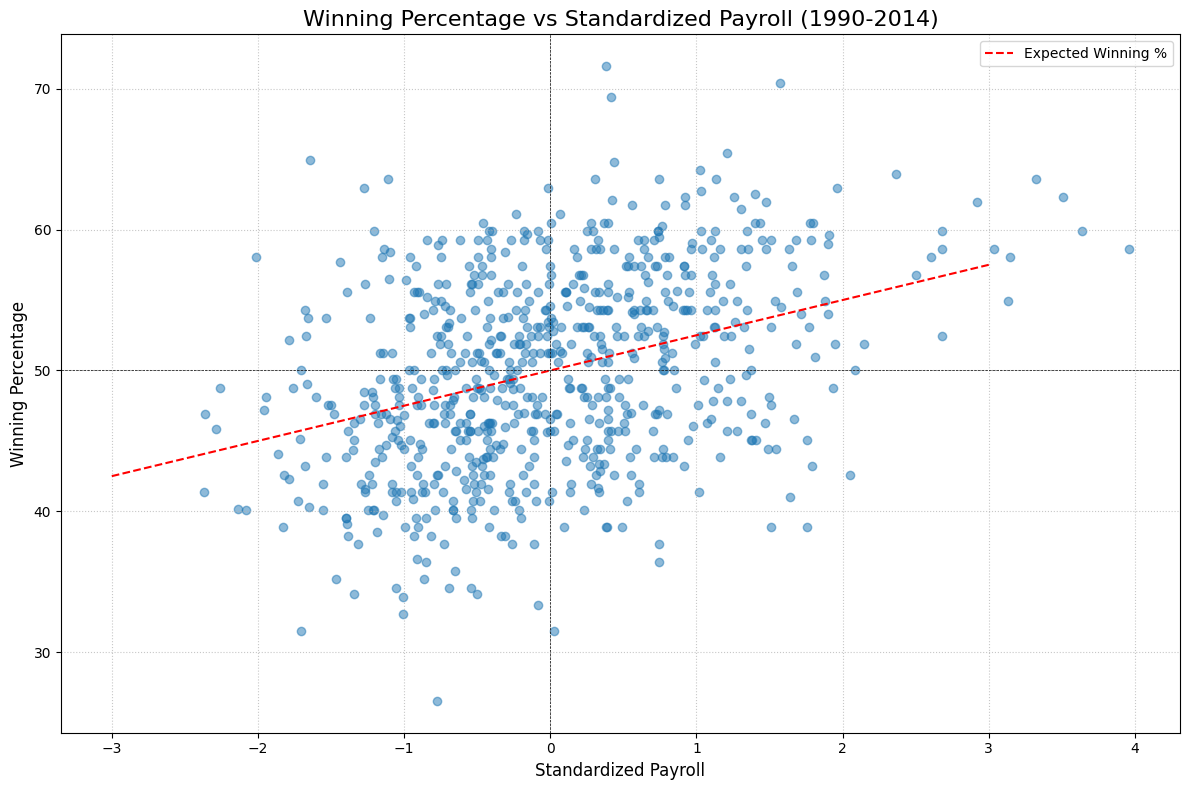

Correlation between standardized payroll and winning percentage: 0.38926330535642356

Top 10 most efficient team-seasons:
     yearID teamID  standardized_payroll  winning_percentage  \
332    2001    SEA              0.379047           71.604938   
122    1994    MON             -1.646081           64.912281   
141    1995    CLE              0.418796           69.444444   
236    1998    NYA              1.573223           70.370370   
358    2002    OAK             -1.112298           63.580247   
328    2001    OAK             -1.276715           62.962963   
424    2004    SLN              0.432796           64.814815   
4      1990    CHA             -2.009859           58.024691   
230    1998    HOU             -0.015307           62.962963   
544    2008    TBA             -1.208261           59.876543   

     expected_win_pct  efficiency  
332         50.947618   20.657320  
122         45.884798   19.027483  
141         51.046991   18.397454  
236         53.933056   16.43

In [ ]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Connect to the SQLite database
sqlite_file = '/content/drive/My Drive/lahman_1871-2022.sqlite'
conn = sqlite3.connect(sqlite_file)

# Query to get payroll and winning percentage data for all teams from 1990 to 2014
query = """
SELECT
    s.yearID,
    s.teamID,
    SUM(s.salary) as total_payroll,
    t.W * 100.0 / t.G AS winning_percentage
FROM Salaries s
JOIN Teams t ON s.yearID = t.yearID AND s.teamID = t.teamID
WHERE s.yearID BETWEEN 1990 AND 2014
GROUP BY s.yearID, s.teamID
"""

# Execute the query and load results into a DataFrame
df = pd.read_sql_query(query, conn)

# Close the connection
conn.close()

# Standardize payroll within each year
def standardize_payroll(group):
    mean = group['total_payroll'].mean()
    std = group['total_payroll'].std()
    group['standardized_payroll'] = (group['total_payroll'] - mean) / std
    return group

df = df.groupby('yearID').apply(standardize_payroll).reset_index(drop=True)

# Calculate expected winning percentage
df['expected_win_pct'] = 50 + 2.5 * df['standardized_payroll']

# Calculate efficiency (actual - expected winning percentage)
df['efficiency'] = df['winning_percentage'] - df['expected_win_pct']

# Create the plot
plt.figure(figsize=(12, 8))

# Scatter plot of actual winning percentage vs standardized payroll
plt.scatter(df['standardized_payroll'], df['winning_percentage'], alpha=0.5)

# Plot the expected winning percentage line
x = np.array([-3, 3])  # Range of standardized payroll
y = 50 + 2.5 * x
plt.plot(x, y, color='red', linestyle='--', label='Expected Winning %')

# Customize the plot
plt.title('Winning Percentage vs Standardized Payroll (1990-2014)', fontsize=16)
plt.xlabel('Standardized Payroll', fontsize=12)
plt.ylabel('Winning Percentage', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle=':', alpha=0.7)

# Add reference lines
plt.axvline(x=0, color='k', linestyle='--', linewidth=0.5)
plt.axhline(y=50, color='k', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

# Print summary statistics
print("Correlation between standardized payroll and winning percentage:",
      df['standardized_payroll'].corr(df['winning_percentage']))

print("\nTop 10 most efficient team-seasons:")
print(df.nlargest(10, 'efficiency')[['yearID', 'teamID', 'standardized_payroll', 'winning_percentage', 'expected_win_pct', 'efficiency']])

print("\nBottom 10 least efficient team-seasons:")
print(df.nsmallest(10, 'efficiency')[['yearID', 'teamID', 'standardized_payroll', 'winning_percentage', 'expected_win_pct', 'efficiency']])

# Calculate average efficiency for each team
team_efficiency = df.groupby('teamID')['efficiency'].mean().sort_values(ascending=False)

print("\nTop 10 most efficient teams on average:")
print(team_efficiency.head(10))

print("\nBottom 10 least efficient teams on average:")
print(team_efficiency.tail(10))


# Problem 7

<ipython-input-38-3f790b38530e>:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('yearID').apply(standardize_payroll).reset_index(drop=True)


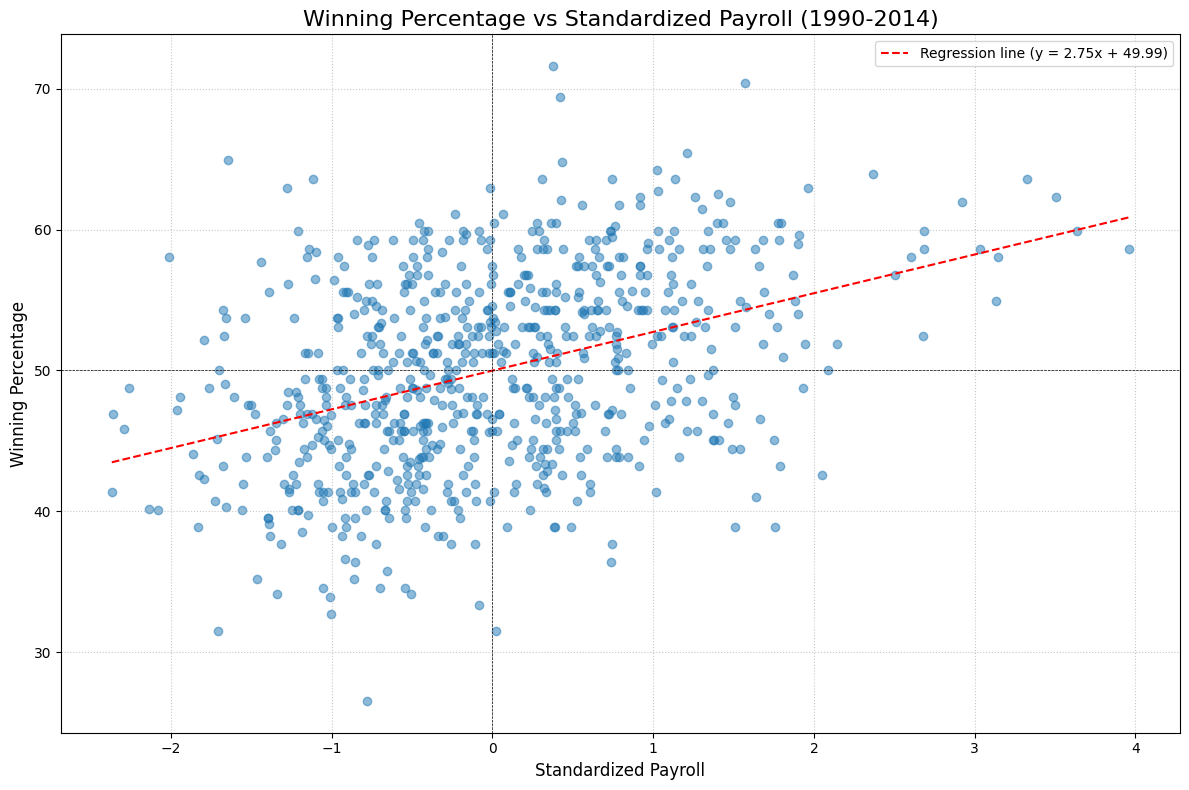

Regression equation: y = 2.75x + 49.99
R-squared: 0.1515

Correlation between standardized payroll and winning percentage: 0.38926330535642356

Top 10 most efficient team-seasons:
     yearID teamID  standardized_payroll  winning_percentage  \
332    2001    SEA              0.379047           71.604938   
122    1994    MON             -1.646081           64.912281   
141    1995    CLE              0.418796           69.444444   
358    2002    OAK             -1.112298           63.580247   
328    2001    OAK             -1.276715           62.962963   
236    1998    NYA              1.573223           70.370370   
424    2004    SLN              0.432796           64.814815   
4      1990    CHA             -2.009859           58.024691   
544    2008    TBA             -1.208261           59.876543   
230    1998    HOU             -0.015307           62.962963   

     expected_win_pct  efficiency  
332         51.030105   20.574833  
122         45.465428   19.446852  
141    

In [ ]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Connect to the SQLite database
sqlite_file = '/content/drive/My Drive/lahman_1871-2022.sqlite'
conn = sqlite3.connect(sqlite_file)

# Query to get payroll and winning percentage data for all teams from 1990 to 2014
query = """
SELECT
    s.yearID,
    s.teamID,
    SUM(s.salary) as total_payroll,
    t.W * 100.0 / t.G AS winning_percentage
FROM Salaries s
JOIN Teams t ON s.yearID = t.yearID AND s.teamID = t.teamID
WHERE s.yearID BETWEEN 1990 AND 2014
GROUP BY s.yearID, s.teamID
"""

# Execute the query and load results into a DataFrame
df = pd.read_sql_query(query, conn)

# Close the connection
conn.close()

# Standardize payroll within each year
def standardize_payroll(group):
    mean = group['total_payroll'].mean()
    std = group['total_payroll'].std()
    group['standardized_payroll'] = (group['total_payroll'] - mean) / std
    return group

df = df.groupby('yearID').apply(standardize_payroll).reset_index(drop=True)

# Calculate the regression line
slope, intercept, r_value, p_value, std_err = stats.linregress(df['standardized_payroll'], df['winning_percentage'])

# Calculate expected winning percentage using the actual coefficients
df['expected_win_pct'] = intercept + slope * df['standardized_payroll']

# Calculate efficiency (actual - expected winning percentage)
df['efficiency'] = df['winning_percentage'] - df['expected_win_pct']

# Create the plot
plt.figure(figsize=(12, 8))

# Scatter plot of actual winning percentage vs standardized payroll
plt.scatter(df['standardized_payroll'], df['winning_percentage'], alpha=0.5)

# Plot the regression line
x = np.array([df['standardized_payroll'].min(), df['standardized_payroll'].max()])
y = intercept + slope * x
plt.plot(x, y, color='red', linestyle='--', label=f'Regression line (y = {slope:.2f}x + {intercept:.2f})')

# Customize the plot
plt.title('Winning Percentage vs Standardized Payroll (1990-2014)', fontsize=16)
plt.xlabel('Standardized Payroll', fontsize=12)
plt.ylabel('Winning Percentage', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle=':', alpha=0.7)

# Add reference lines
plt.axvline(x=0, color='k', linestyle='--', linewidth=0.5)
plt.axhline(y=50, color='k', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

# Print regression equation and R-squared
print(f"Regression equation: y = {slope:.2f}x + {intercept:.2f}")
print(f"R-squared: {r_value**2:.4f}")

# Print summary statistics
print("\nCorrelation between standardized payroll and winning percentage:",
      df['standardized_payroll'].corr(df['winning_percentage']))

print("\nTop 10 most efficient team-seasons:")
print(df.nlargest(10, 'efficiency')[['yearID', 'teamID', 'standardized_payroll', 'winning_percentage', 'expected_win_pct', 'efficiency']])

print("\nBottom 10 least efficient team-seasons:")
print(df.nsmallest(10, 'efficiency')[['yearID', 'teamID', 'standardized_payroll', 'winning_percentage', 'expected_win_pct', 'efficiency']])

# Calculate average efficiency for each team
team_efficiency = df.groupby('teamID')['efficiency'].mean().sort_values(ascending=False)

print("\nTop 10 most efficient teams on average:")
print(team_efficiency.head(10))

print("\nBottom 10 least efficient teams on average:")
print(team_efficiency.tail(10))

# Spending efficiency

<ipython-input-40-e7251f22f28a>:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('yearID').apply(standardize_payroll).reset_index(drop=True)


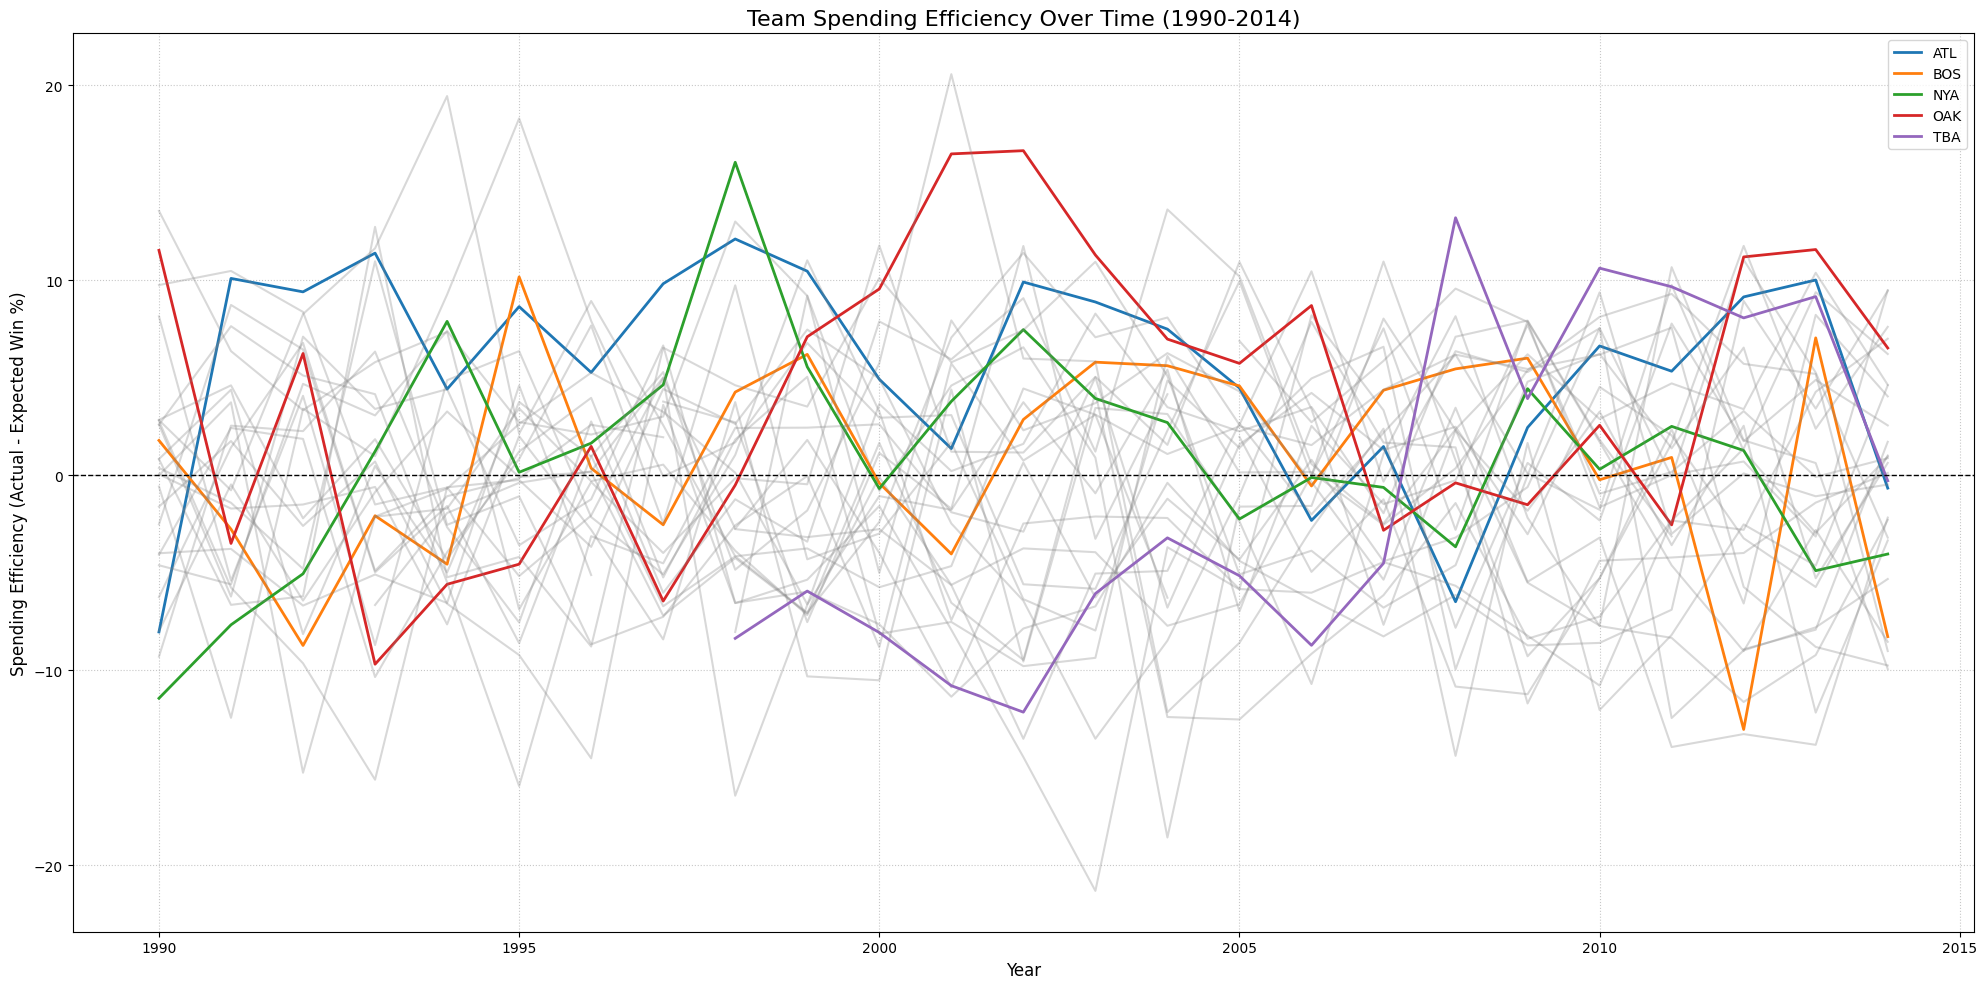


OAK Summary:
Average Efficiency: 3.85
Best Year: 2002 (Efficiency: 16.65)
Worst Year: 1993 (Efficiency: -9.68)

NYA Summary:
Average Efficiency: 0.93
Best Year: 1998 (Efficiency: 16.05)
Worst Year: 1990 (Efficiency: -11.43)

BOS Summary:
Average Efficiency: 0.73
Best Year: 1995 (Efficiency: 10.18)
Worst Year: 2012 (Efficiency: -13.03)

ATL Summary:
Average Efficiency: 5.45
Best Year: 1998 (Efficiency: 12.12)
Worst Year: 1990 (Efficiency: -8.03)

TBA Summary:
Average Efficiency: -1.09
Best Year: 2008 (Efficiency: 13.21)
Worst Year: 2002 (Efficiency: -12.14)


In [ ]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Connect to the SQLite database
sqlite_file = '/content/drive/My Drive/lahman_1871-2022.sqlite'
conn = sqlite3.connect(sqlite_file)

# Query to get payroll and winning percentage data for all teams from 1990 to 2014
query = """
SELECT
    s.yearID,
    s.teamID,
    SUM(s.salary) as total_payroll,
    t.W * 100.0 / t.G AS winning_percentage
FROM Salaries s
JOIN Teams t ON s.yearID = t.yearID AND s.teamID = t.teamID
WHERE s.yearID BETWEEN 1990 AND 2014
GROUP BY s.yearID, s.teamID
"""

# Execute the query and load results into a DataFrame
df = pd.read_sql_query(query, conn)

# Close the connection
conn.close()

# Standardize payroll within each year
def standardize_payroll(group):
    mean = group['total_payroll'].mean()
    std = group['total_payroll'].std()
    group['standardized_payroll'] = (group['total_payroll'] - mean) / std
    return group

df = df.groupby('yearID').apply(standardize_payroll).reset_index(drop=True)

# Calculate expected winning percentage using the actual coefficients
slope, intercept = 2.75, 49.99  # From the regression equation you provided
df['expected_win_pct'] = intercept + slope * df['standardized_payroll']

# Calculate efficiency (actual - expected winning percentage)
df['efficiency'] = df['winning_percentage'] - df['expected_win_pct']

# Create a pivot table for easier plotting
efficiency_pivot = df.pivot(index='yearID', columns='teamID', values='efficiency')

# Create the plot
plt.figure(figsize=(20, 10))

# Teams to highlight (you can modify this list)
highlight_teams = ['OAK', 'NYA', 'BOS', 'ATL', 'TBA']

# Plot each team's efficiency over time
for team in efficiency_pivot.columns:
    if team in highlight_teams:
        plt.plot(efficiency_pivot.index, efficiency_pivot[team], label=team, linewidth=2)
    else:
        plt.plot(efficiency_pivot.index, efficiency_pivot[team], color='gray', alpha=0.3)

# Customize the plot
plt.title('Team Spending Efficiency Over Time (1990-2014)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Spending Efficiency (Actual - Expected Win %)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle=':', alpha=0.7)

# Add reference line at y=0
plt.axhline(y=0, color='k', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()

# Print summary statistics for highlighted teams
for team in highlight_teams:
    team_data = df[df['teamID'] == team]
    print(f"\n{team} Summary:")
    print(f"Average Efficiency: {team_data['efficiency'].mean():.2f}")
    print(f"Best Year: {team_data.loc[team_data['efficiency'].idxmax(), 'yearID']} (Efficiency: {team_data['efficiency'].max():.2f})")
    print(f"Worst Year: {team_data.loc[team_data['efficiency'].idxmin(), 'yearID']} (Efficiency: {team_data['efficiency'].min():.2f})")

# Problem 8

<ipython-input-41-614a9cc74e71>:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('yearID').apply(standardize_payroll).reset_index(drop=True)


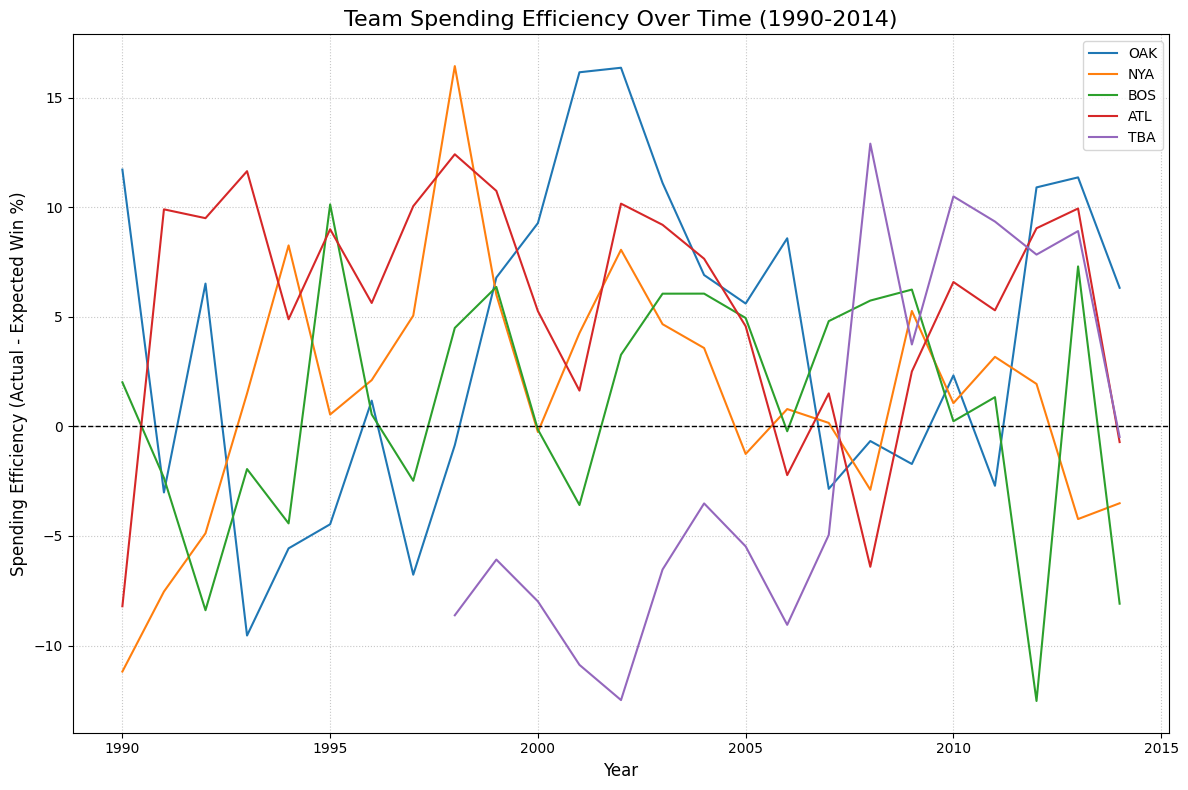


OAK Summary:
Average Efficiency: 3.72
Best Year: 2002 (Efficiency: 16.36)
Worst Year: 1993 (Efficiency: -9.54)

NYA Summary:
Average Efficiency: 1.48
Best Year: 1998 (Efficiency: 16.44)
Worst Year: 1990 (Efficiency: -11.19)

BOS Summary:
Average Efficiency: 1.01
Best Year: 1995 (Efficiency: 10.13)
Worst Year: 2012 (Efficiency: -12.53)

ATL Summary:
Average Efficiency: 5.58
Best Year: 1998 (Efficiency: 12.41)
Worst Year: 1990 (Efficiency: -8.21)

TBA Summary:
Average Efficiency: -1.34
Best Year: 2008 (Efficiency: 12.90)
Worst Year: 2002 (Efficiency: -12.49)


In [ ]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# Connect to the SQLite database
sqlite_file = '/content/drive/My Drive/lahman_1871-2022.sqlite'
conn = sqlite3.connect(sqlite_file)

# Query to get payroll and winning percentage data for all teams from 1990 to 2014
query = """
SELECT
    s.yearID,
    s.teamID,
    SUM(s.salary) as total_payroll,
    t.W * 100.0 / t.G AS winning_percentage
FROM Salaries s
JOIN Teams t ON s.yearID = t.yearID AND s.teamID = t.teamID
WHERE s.yearID BETWEEN 1990 AND 2014
GROUP BY s.yearID, s.teamID
"""

# Execute the query and load results into a DataFrame
df = pd.read_sql_query(query, conn)
conn.close()

# Standardize payroll within each year
def standardize_payroll(group):
    mean = group['total_payroll'].mean()
    std = group['total_payroll'].std()
    group['standardized_payroll'] = (group['total_payroll'] - mean) / std
    return group

df = df.groupby('yearID').apply(standardize_payroll).reset_index(drop=True)

# Calculate expected winning percentage
df['expected_win_pct'] = 50 + 2.5 * df['standardized_payroll']

# Calculate efficiency
df['efficiency'] = df['winning_percentage'] - df['expected_win_pct']

# Teams to plot
teams_to_plot = ['OAK', 'NYA', 'BOS', 'ATL', 'TBA']

# Create the plot
plt.figure(figsize=(12, 8))

for team in teams_to_plot:
    team_data = df[df['teamID'] == team]
    plt.plot(team_data['yearID'], team_data['efficiency'], label=team)

plt.title('Team Spending Efficiency Over Time (1990-2014)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Spending Efficiency (Actual - Expected Win %)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle=':', alpha=0.7)
plt.axhline(y=0, color='k', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()

# Print summary statistics for these teams
for team in teams_to_plot:
    team_data = df[df['teamID'] == team]
    print(f"\n{team} Summary:")
    print(f"Average Efficiency: {team_data['efficiency'].mean():.2f}")
    print(f"Best Year: {team_data.loc[team_data['efficiency'].idxmax(), 'yearID']} (Efficiency: {team_data['efficiency'].max():.2f})")
    print(f"Worst Year: {team_data.loc[team_data['efficiency'].idxmin(), 'yearID']} (Efficiency: {team_data['efficiency'].min():.2f})")

# Question 4:
## What can you learn from this plot compared to the set of plots you looked at in Question 2 and 3? How good was Oakland's efficiency during the Moneyball period?

Based on the data from Questions 2 and 3, and comparing it to the efficiency plot over time:

* Oakland's efficiency dramatically improved during the Moneyball period (2000-2004), ranking 2nd out of 30 teams with a high winning percentage (59.70%) despite a low payroll (ranked 25th).

* Pre-Moneyball (1990-1999), Oakland's performance was inconsistent, with moderate efficiency in the early 90s but improving by the late 90s.

* Post-Moneyball (2005-2014), Oakland maintained above-average efficiency, ranking 6th and then 2nd in subsequent periods.
The efficiency plot likely shows a clear spike for Oakland during 2000-2004, visually demonstrating the Moneyball strategy's effectiveness. It also likely illustrates how Oakland outperformed higher-spending teams during this period and how their efficiency advantage gradually decreased in later years as other teams potentially adopted similar strategies.


In conclusion, Oakland's efficiency during the Moneyball period was exceptionally good, achieving top-tier performance with one of the lowest payrolls in the league.